# Semantic Analysis

In [95]:
import os
import pandas as pd
import pickle
import numpy as np

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

plt.rcParams['figure.dpi'] = 600
plt.rcParams['savefig.dpi'] = 600

In [96]:
#path = '/Users/kenzaamara/Storage/syntax-shap'
#data_save_dir = "/Users/kenzaamara/GithubProjects/syntax-shap/data"

path = "/cluster/home/kamara/syntax-shap"
save_dir = "/cluster/work/zhang/kamara/syntax-shap"

dataset = "negation"
model_name = "mistral"
threshold_ = 0.5
seed_ = 0


In [97]:

folder_path = os.path.join(save_dir, f"results/explanations/{model_name}/{dataset}")  # Replace with your folder path

# Initialize a list to store the dataframes
df_list = []

# Loop through each file in the folder
for root, dirs, files in os.walk(folder_path):
    for file in files:
        full_path = os.path.join(root, file)
        parts = file.split('_')
        if (file.endswith('.pkl')):
            # Extract dataset, model name, and algorithm from the filename
            dataset = parts[-4]
            model_name = parts[-3]
            algorithm = parts[-2]
            seed = parts[-1].split('.pkl')[0]  # Removes the file extension
           
            if eval(seed) == seed_:
                # Construct the full file path
                file_path = os.path.join(folder_path, file)

                # Read the pickle file
                with open(full_path, 'rb') as file:
                    data = pickle.load(file)

                # Assuming the content is a dictionary, create a DataFrame
                df = pd.DataFrame(data)
                # Add the extracted details as new columns
                df['algorithm'] = algorithm
                df['explanation'] = df['explanation'].apply(lambda x: x.reshape(-1))

                # Append to the list of dataframes
                df_list.append(df)

# Concatenate all dataframes in the list
df_explanation = pd.concat(df_list, ignore_index=True)
df_explanation


,input_id,input,tokens,token_ids,explanation,algorithm
0,172,A bat flies without,"[<s>, A, bat, flies, without]","[1, 330, 9753, 28030, 1671]","[-1.4712268, -0.89945465, 0.36907044, -1.5608546]",svsampling
1,464,A dolphin sees without,"[<s>, A, dol, ph, in, sees, without]","[1, 330, 13824, 721, 262, 12477, 1671]","[-0.96523803, -0.6508136, 0.07779602, -0.12909...",svsampling
2,196,A monkey walks without,"[<s>, A, mon, key, walks, without]","[1, 330, 1326, 1499, 16830, 1671]","[-0.8556219, -0.2594735, -0.18704407, -0.40751...",svsampling
3,414,Peter is a groom without a,"[<s>, Peter, is, a, groom, without, a]","[1, 5966, 349, 264, 28583, 1671, 264]","[-0.56217575, -0.6185286, -0.37080443, -0.0807...",svsampling
4,530,A person has no,"[<s>, A, person, has, no]","[1, 330, 1338, 659, 708]","[-0.69703627, -0.8620669, -0.5382457, -1.1627676]",svsampling
...,...,...,...,...,...,...
3531,70,Anaheim is not located in,"[<s>, Ana, heim, is, not, located, in]","[1, 23103, 9733, 349, 459, 5651, 297]","[0.1733647529316892, 0.04061554155962106, -0.0...",syntax
3532,277,A chicken has,"[<s>, A, chicken, has]","[1, 330, 13088, 659]","[-0.20917350576438654, -0.49107935620356624, -...",syntax
3533,9,A dad is a,"[<s>, A, dad, is, a]","[1, 330, 9493, 349, 264]","[0.07411319335176675, -0.03953009075144326, 0....",syntax
3534,359,Kate is a aunt with a,"[<s>, Kate, is, a, aunt, with, a]","[1, 14976, 349, 264, 23785, 395, 264]","[-0.043608159481715016, 0.12664847689797767, 0...",syntax


In [98]:
df_random = df_explanation[df_explanation.algorithm=='random'][['tokens','token_ids','input_id']]
df_explanation = df_explanation.drop(['tokens','token_ids'], axis=1)
df_explanation = pd.merge(df_explanation, df_random, on='input_id', how='inner')#
df_explanation['n_token'] = df_explanation['tokens'].apply(len)

## Without and the uninteresting predictions "a" and "the"...

In [26]:
df_explanation['without'] = df_explanation['input'].apply(lambda x: x.endswith('without') or x.endswith('with'))
df_without = df_explanation[df_explanation['without']==True]

In [27]:
df_str = pd.read_csv(os.path.join(path, f"data/{dataset}/seed_{seed_}/{dataset}_{model_name}_{seed_}_predictions.csv"))
labels = ["a", "the"]

df_str

,input_id,input,y
0,0,A boy is not a,fool
1,1,A boy is a,young
2,2,A girl is not a,girl
3,3,A girl is a,girl
4,4,A brother is not a,murderer
...,...,...,...
529,529,A person has,no
530,530,A person has no,right
531,531,A person has,no
532,532,A person does not have,to


In [28]:
df_w = pd.merge(df_without, df_str, on=['input', 'input_id'])

In [29]:
df_w['tokens'] = df_w['input'].apply(lambda x: x.split())
df_w['without_pos'] = df_w['tokens'].apply(lambda x: [i for i, j in enumerate(x) if j in ['without', 'with']])

In [30]:
df_w['without_rank']= df_w.apply(lambda x: np.where(np.flip(np.argsort(x['explanation']))==x['without_pos'])[0].item()+1, axis=1)

ValueError: Expected a 1D array, got an array with shape (0, 10)

In [17]:
def is_a(x):
    return 'a'in x.split() or 'the' in x.split()

df_w['is_a'] = df_w['y'].apply(lambda x: is_a(str(x)))
df_a = df_w[df_w['is_a']==True]
df_a

,input_id,input,explanation,algorithm,tokens,token_ids,n_token,without,y,without_pos,without_rank,is_a
7,464,A dolphin sees without,"[-0.96523803, -0.6508136, 0.07779602, -0.12909...",svsampling,"[A, dolphin, sees, without]","[1, 330, 13824, 721, 262, 12477, 1671]",7,True,the,[3],2,True
8,464,A dolphin sees without,"[0.0007105398999688524, 0.0009309598827735322,...",random,"[A, dolphin, sees, without]","[1, 330, 13824, 721, 262, 12477, 1671]",7,True,the,[3],5,True
9,464,A dolphin sees without,"[-0.9348297, -0.5663223, -0.64123535, -0.72370...",ablation,"[A, dolphin, sees, without]","[1, 330, 13824, 721, 262, 12477, 1671]",7,True,the,[3],5,True
10,464,A dolphin sees without,"[-0.07931209257022506, 0.004841353363672148, 0...",syntax-w,"[A, dolphin, sees, without]","[1, 330, 13824, 721, 262, 12477, 1671]",7,True,the,[3],3,True
11,464,A dolphin sees without,"[-3288.8130806684494, 1969.1869193315506, -644...",hedge,"[A, dolphin, sees, without]","[1, 330, 13824, 721, 262, 12477, 1671]",7,True,the,[3],1,True
...,...,...,...,...,...,...,...,...,...,...,...,...
800,431,A horse sees with,"[-1.9039764, -2.320881, -2.2635994, -1.6345711]",ablation,"[A, horse, sees, with]","[1, 330, 7947, 12477, 395]",5,True,the,[3],1,True
801,431,A horse sees with,"[-0.09217678430281785, -0.11807190513611567, 0...",syntax-w,"[A, horse, sees, with]","[1, 330, 7947, 12477, 395]",5,True,the,[3],1,True
802,431,A horse sees with,"[-826.4635619521141, -870.4635619521141, -460....",hedge,"[A, horse, sees, with]","[1, 330, 7947, 12477, 395]",5,True,the,[3],1,True
803,431,A horse sees with,"[-3.2700766550181154e-05, 1.6938216364844484e-...",lime,"[A, horse, sees, with]","[1, 330, 7947, 12477, 395]",5,True,the,[3],3,True


In [18]:
df_a['input_id'].nunique()

112

In [19]:
df_a.groupby(['algorithm']).mean(numeric_only=True).reset_index()


,algorithm,input_id,n_token,without,without_rank,is_a
0,ablation,322.366071,5.642857,1.0,2.178571,1.0
1,hedge,322.366071,5.642857,1.0,2.366071,1.0
2,lime,345.285714,5.000000,1.0,2.142857,1.0
3,random,322.366071,5.642857,1.0,2.839286,1.0
4,svsampling,322.366071,5.642857,1.0,2.857143,1.0
5,syntax,322.366071,5.642857,1.0,3.107143,1.0
6,syntax-w,322.366071,5.642857,1.0,2.776786,1.0


                 [1.0, 2.0)  [2.0, 3.0)  [3.0, 4.0)  [4.0, inf)
algorithm                                                      
Random            23.214286   20.535714   21.428571   34.821429
LIME              17.857143   50.000000   32.142857    0.000000
FeatureAblation   42.857143   24.107143    9.821429   23.214286
SampleShapley     16.071429   25.000000   18.750000   40.178571
Partition         42.857143   17.857143    9.821429   29.464286
SyntaxShap        28.571429    8.035714   21.428571   41.964286
SyntaxShap-W      41.964286    9.821429   12.500000   35.714286
                 [1.0, 2.0)  [2.0, 3.0)  [3.0, 4.0)  [4.0, inf)
algorithm                                                      
Random            23.214286   20.535714   21.428571   34.821429
LIME              17.857143   50.000000   32.142857    0.000000
FeatureAblation   42.857143   24.107143    9.821429   23.214286
SampleShapley     16.071429   25.000000   18.750000   40.178571
Partition         42.857143   17.857143 

FileNotFoundError: [Errno 2] No such file or directory: '/cluster/home/kamara/syntax-shap/figures/semantic_analysis/negation_mistral_seed_0_with_without_ranks.png'

<Figure size 2400x2400 with 0 Axes>

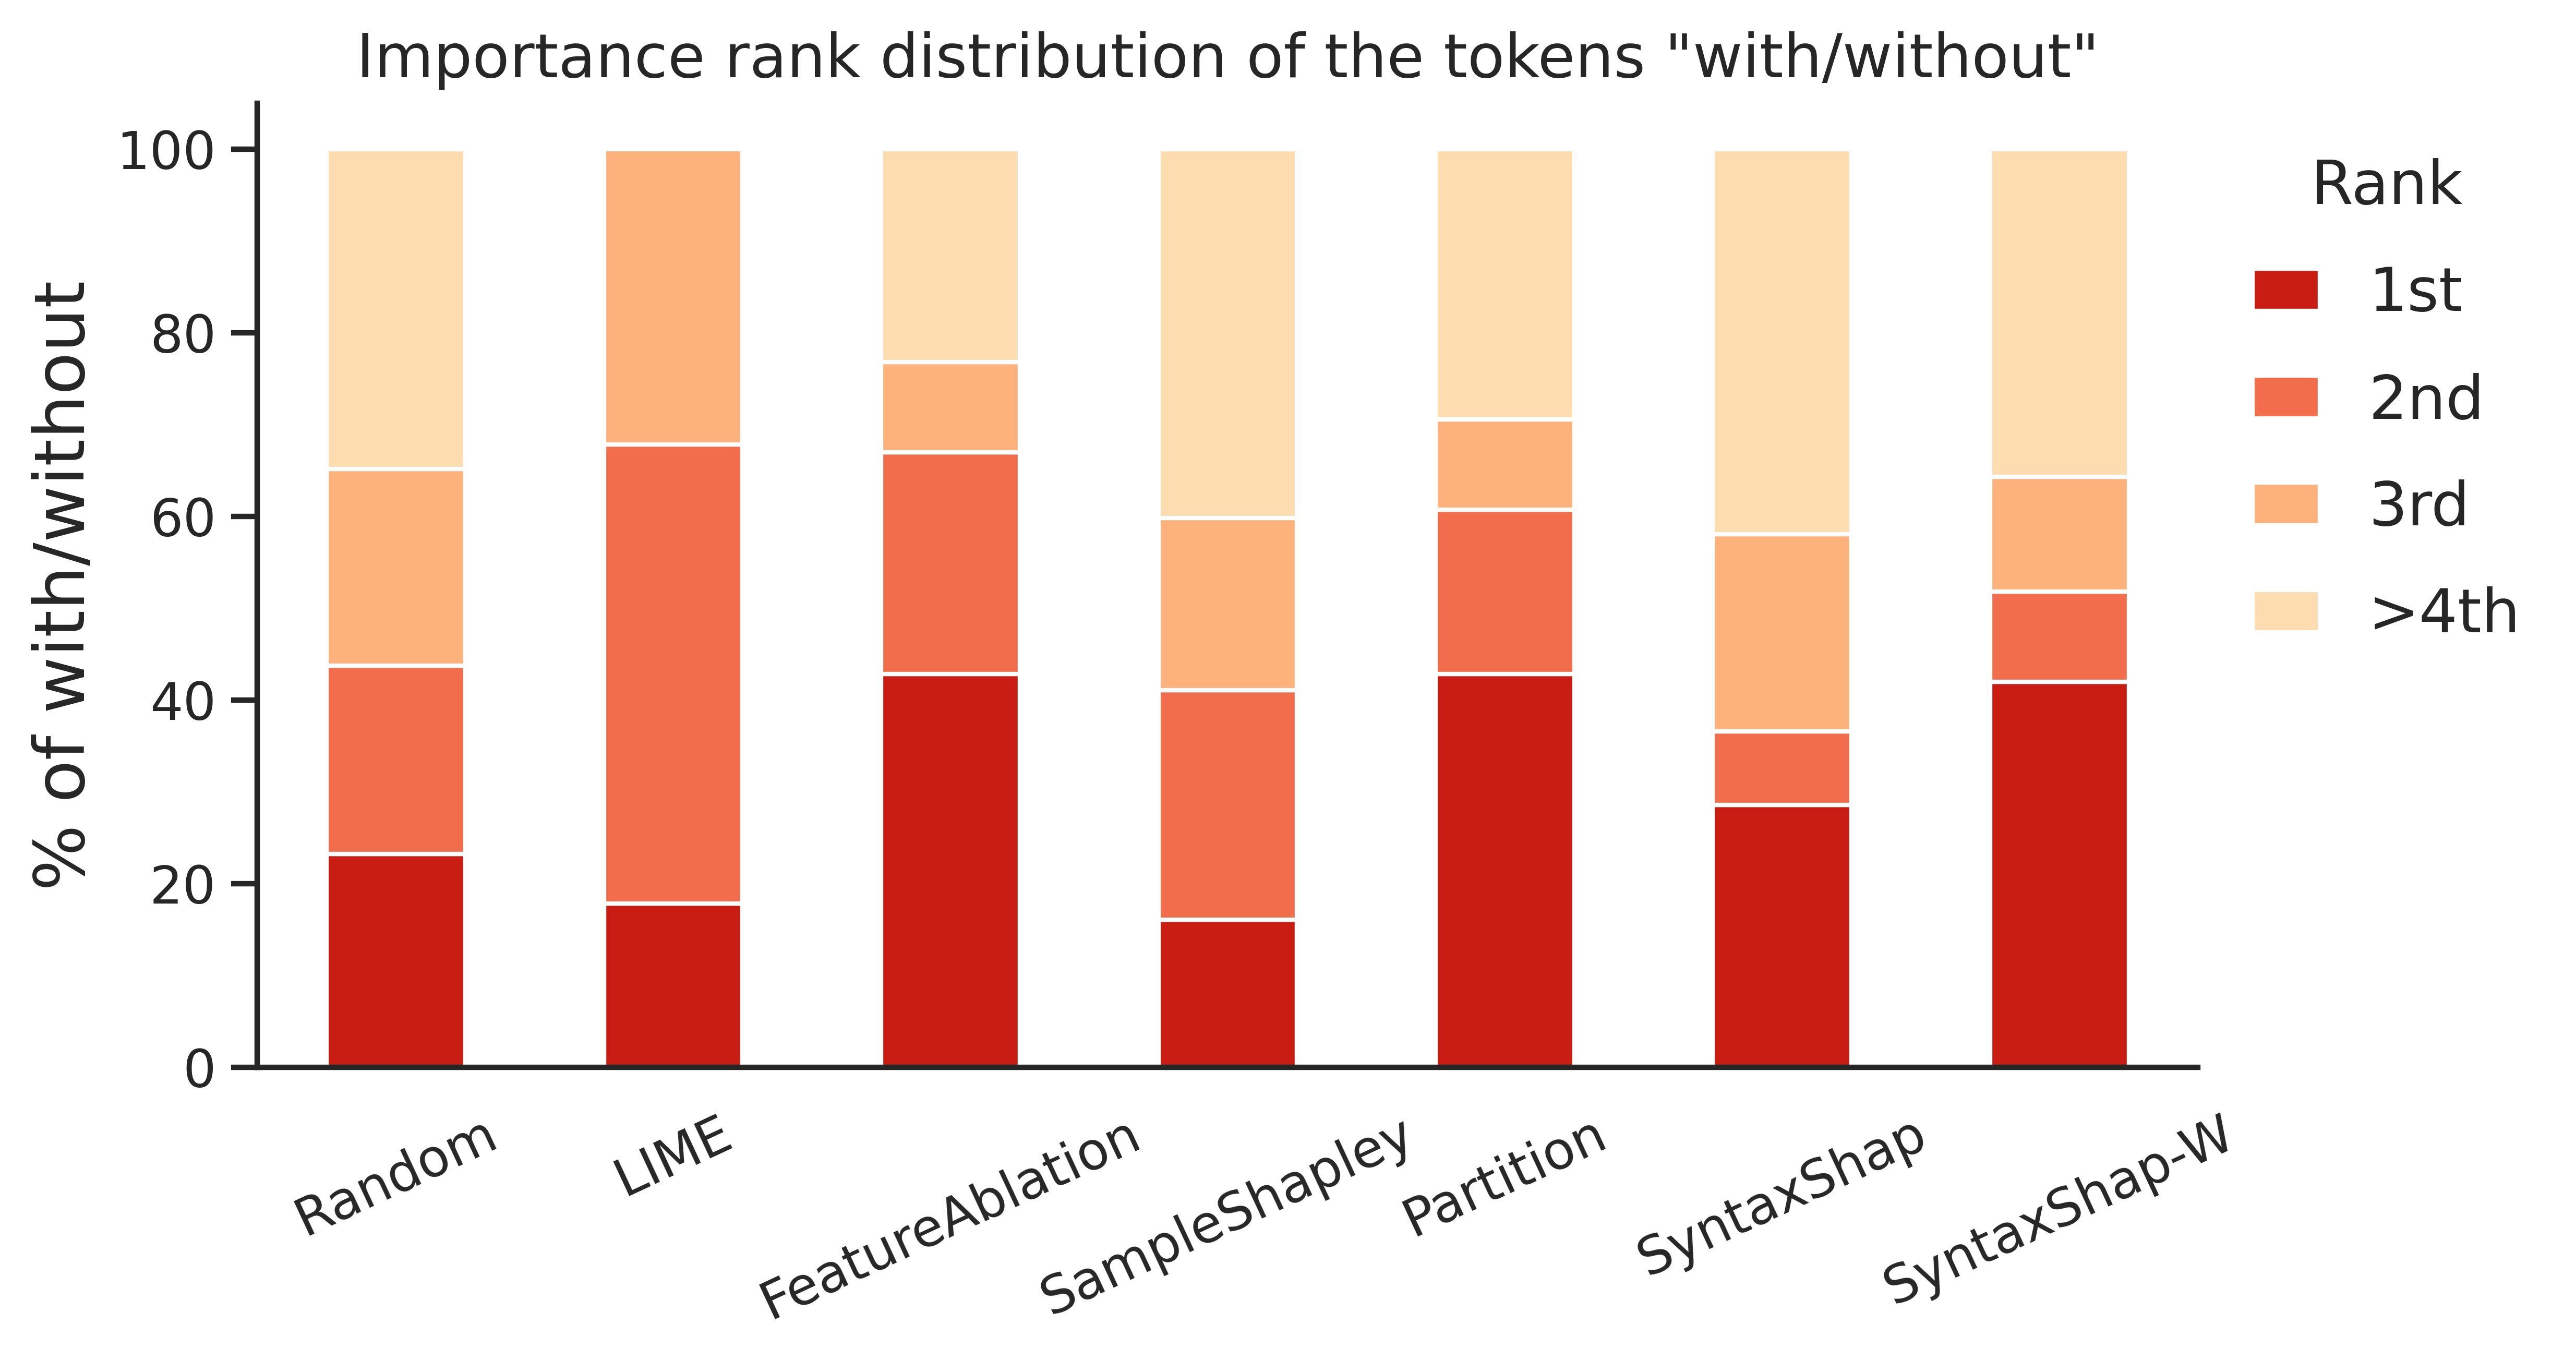

In [20]:

df = df_a

# Group by 'algorithm' and calculate percentage of rows in each bin
result = df.groupby('algorithm')['without_rank'].apply(lambda x: pd.cut(x, bins=[1, 2, 3, 4, float('inf')], right=False).value_counts(normalize=True) * 100).unstack().fillna(0)
#result.reset_index(inplace=True)
# Reorder rows and rename index
result = result.rename(index={'lime': 'LIME', 'ablation': 'FeatureAblation', 'svsampling': 'SampleShapley', 'hedge': 'Partition', 'syntax': 'SyntaxShap', 'syntax-w': 'SyntaxShap-W', 'random': 'Random'})
result = result.reindex(["Random", "LIME", "FeatureAblation","SampleShapley", "Partition", "SyntaxShap", "SyntaxShap-W"])

print(result)



sns.set_style("ticks")
sns.set_context("notebook", rc={"xtick.labelsize" : 12, "ytick.labelsize" : 12})
# Plot with increasing hue from Viridis colormap
plt.figure(figsize=(4,4))
result.plot(kind='bar', stacked=True, color=sns.color_palette("OrRd_r", n_colors=len(result.columns)), width=0.5, edgecolor='white', figsize=(8,4))

plt.title('Importance rank distribution of the tokens "with/without"', fontsize=14)
plt.xlabel('')
plt.ylabel('% of with/without', fontsize=16)
plt.xticks(rotation=25)
# Remove x ticks
plt.tick_params(axis='x', which='both', bottom=False)

# Move the legend outside on the upper right side of the plot
# Rewrite legend with custom labels and title
leg = plt.legend(labels=['1st', '2nd', '3rd', '>4th'], title='Rank', bbox_to_anchor=(1, 1), fontsize=14, loc='upper left', frameon=False, handlelength=1.1, labelspacing=0.8)
leg.get_title().set_fontsize('14')  # Increase legend title font size
for line in leg.get_lines():
    line.set_linewidth(3)  # Increase line width in legend

sns.despine()

#plt.tight_layout()
print(result)
plt.savefig(f"{path}/figures/semantic_analysis/{dataset}_{model_name}_seed_{seed_}_with_without_ranks.png", bbox_inches='tight', dpi=600)
plt.show()


## Importance of Negations when the model does not capture them

In [99]:

folder_path = os.path.join(save_dir, f"results/scores/{model_name}/{dataset}")  # Replace with your folder path

# Initialize a list to store the dataframes
df_list = []

# Loop through each file in the folder
for root, dirs, files in os.walk(folder_path):
    for file in files:
        full_path = os.path.join(root, file)
        parts = file.split('_')
        if (file.endswith('.pkl')):
            # Extract dataset, model name, and algorithm from the filename
            dataset = parts[-5]
            model_name = parts[-4]
            algorithm = parts[-3]
            seed = parts[-2]
            threshold = parts[-1].split('.pkl')[0]  # Removes the file extension

            if (eval(threshold) == threshold_) and (eval(seed) == seed_):
                # Construct the full file path
                file_path = os.path.join(folder_path, file)

                # Read the pickle file
                with open(full_path, 'rb') as file:
                    data = pickle.load(file)

                # Assuming the content is a dictionary, create a DataFrame
                df = pd.DataFrame(data)
                # Add the extracted details as new columns
                df['algorithm'] = algorithm

                # Append to the list of dataframes
                df_list.append(df)

df_final_single_threshold = pd.concat(df_list, ignore_index=True)
df_final_single_threshold


,fid_keep_rd,fid_keep,fid_rmv,log_odds_keep,acc_at_k,prob_diff_at_k,input_id,input,tokens,token_ids,algorithm
0,0.015786,0.015786,0.015786,-9.666951,0.2,0.813961,172,A bat flies without,"[<s>, A, bat, flies, without]","[1, 330, 9753, 28030, 1671]",svsampling
1,0.339979,0.339979,0.339979,-12.736641,0.0,0.852288,464,A dolphin sees without,"[<s>, A, dol, ph, in, sees, without]","[1, 330, 13824, 721, 262, 12477, 1671]",svsampling
2,0.003232,0.003232,-0.003799,-8.081125,0.2,0.728337,196,A monkey walks without,"[<s>, A, mon, key, walks, without]","[1, 330, 1326, 1499, 16830, 1671]",svsampling
3,-0.104589,-0.018243,0.036701,0.403502,0.4,0.151361,414,Peter is a groom without a,"[<s>, Peter, is, a, groom, without, a]","[1, 5966, 349, 264, 28583, 1671, 264]",svsampling
4,0.035392,0.035392,0.035392,-10.474270,0.0,0.658700,530,A person has no,"[<s>, A, person, has, no]","[1, 330, 1338, 659, 708]",svsampling
...,...,...,...,...,...,...,...,...,...,...,...
3531,0.339024,0.312806,0.035620,-2.559597,0.3,0.742238,70,Anaheim is not located in,"[<s>, Ana, heim, is, not, located, in]","[1, 23103, 9733, 349, 459, 5651, 297]",syntax
3532,0.435377,0.435377,0.162397,-12.983969,0.1,0.679344,277,A chicken has,"[<s>, A, chicken, has]","[1, 330, 13088, 659]",syntax
3533,0.006199,-0.006636,0.006199,0.727723,0.2,0.518250,9,A dad is a,"[<s>, A, dad, is, a]","[1, 330, 9493, 349, 264]",syntax
3534,-0.077121,0.002778,0.030692,-0.064259,0.2,0.457576,359,Kate is a aunt with a,"[<s>, Kate, is, a, aunt, with, a]","[1, 14976, 349, 264, 23785, 395, 264]",syntax


In [100]:
df_random = df_final_single_threshold[df_final_single_threshold.algorithm=='random'][['tokens','token_ids','input_id']]
df_final_single_threshold = df_final_single_threshold.drop(['tokens','token_ids'], axis=1)
df_final_single_threshold = pd.merge(df_final_single_threshold, df_random, on='input_id', how='inner')#
df_final_single_threshold['n_token'] = df_final_single_threshold['tokens'].apply(len)

In [101]:
df_str = pd.read_csv(os.path.join(path, f"data/{dataset}/seed_{seed_}/{dataset}_{model_name}_{seed_}_labeled_predictions.csv"))
df_str

,input_id,input,y,label
0,0,A boy is not a,son,NaN
1,1,A boy is a,son,NaN
2,2,A girl is not a,woman,0.0
3,3,A girl is a,girl,1.0
4,4,A brother is not a,son,NaN
...,...,...,...,...
529,529,A person has,died,NaN
530,530,A person has no,right,NaN
531,531,A person has,died,NaN
532,532,A person does not have,to,NaN


In [102]:
df_label = df_str[(df_str['label'].notna()) & (df_str['label'] == 0)]

In [103]:
df_explanation['tokens']

0               [<s>, A, bat, flies, without]
1               [<s>, A, bat, flies, without]
2               [<s>, A, bat, flies, without]
3               [<s>, A, bat, flies, without]
4               [<s>, A, bat, flies, without]
                        ...                  
3531    [<s>, An, ele, phant, walks, without]
3532    [<s>, An, ele, phant, walks, without]
3533    [<s>, An, ele, phant, walks, without]
3534    [<s>, An, ele, phant, walks, without]
3535    [<s>, An, ele, phant, walks, without]
Name: tokens, Length: 3536, dtype: object

In [115]:
sample = pd.merge(df_explanation, df_final_single_threshold.drop(['tokens', 'token_ids'], axis=1), on=['input', 'input_id', 'algorithm', 'n_token'])
negations_gpt2 = [" not", " without", " no"]
negations_mistral = ["not", "without", "no"]

# Function to find the first occurrence of any sublist element in the main list
def find_first_occurrence(main_list, sub_list, keep_prefix=0):
    main_list = main_list[keep_prefix:]
    for element in sub_list:
        if element in main_list:
            return [main_list.index(element)]
    return None  # Return -1 if no element is found
sample['neg_pos'] = sample['tokens'].apply(lambda x: find_first_occurrence(x, negations_mistral, keep_prefix=1))
sample = sample[sample.neg_pos != None]
sample_with_y = pd.merge(sample, df_label, on=['input', 'input_id'])
sample_with_y

,input_id,input,explanation,algorithm,tokens,token_ids,n_token,fid_keep_rd,fid_keep,fid_rmv,log_odds_keep,acc_at_k,prob_diff_at_k,neg_pos,y,label
0,422,Anna is a bride without a,"[-0.72441876, -0.4643852, -0.03718704, -0.5814...",svsampling,"[<s>, Anna, is, a, bride, without, a]","[1, 11106, 349, 264, 25248, 1671, 264]",7,0.025213,0.025213,0.009812,-10.135153,0.0,0.832223,[4],groom,0.0
1,422,Anna is a bride without a,"[0.0007529676281400718, -0.0010791109273092082...",random,"[<s>, Anna, is, a, bride, without, a]","[1, 11106, 349, 264, 25248, 1671, 264]",7,0.464713,0.464713,0.464713,-13.049177,0.0,0.832223,[4],groom,0.0
2,422,Anna is a bride without a,"[0.43296432, -0.14856339, -0.21116257, -1.8525...",ablation,"[<s>, Anna, is, a, bride, without, a]","[1, 11106, 349, 264, 25248, 1671, 264]",7,0.025213,0.025213,-0.003361,-10.135153,0.0,0.832223,[4],groom,0.0
3,422,Anna is a bride without a,"[-0.23767148485093859, -0.3112398093135097, 0....",syntax-w,"[<s>, Anna, is, a, bride, without, a]","[1, 11106, 349, 264, 25248, 1671, 264]",7,0.034462,0.034462,0.034462,-10.447641,0.0,0.824840,[4],groom,0.0
4,422,Anna is a bride without a,"[-5407.508043408394, -47035.508043408394, -627...",hedge,"[<s>, Anna, is, a, bride, without, a]","[1, 11106, 349, 264, 25248, 1671, 264]",7,0.407776,-0.003703,0.464713,0.007937,0.5,0.177549,[4],groom,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,370,John is a husband without a,"[-0.4524765, -1.3515434, -1.0740395, -2.693042...",ablation,"[<s>, John, is, a, husband, without, a]","[1, 2215, 349, 264, 5581, 1671, 264]",7,0.849870,0.849870,0.836500,-13.652841,0.0,0.962460,[4],wife,0.0
119,370,John is a husband without a,"[-0.08299525832534853, -0.09758778247304262, 0...",syntax-w,"[<s>, John, is, a, husband, without, a]","[1, 2215, 349, 264, 5581, 1671, 264]",7,0.846125,0.833364,0.849870,-3.941302,0.1,0.942412,[4],wife,0.0
120,370,John is a husband without a,"[20716.158709317446, -31869.841290682554, -540...",hedge,"[<s>, John, is, a, husband, without, a]","[1, 2215, 349, 264, 5581, 1671, 264]",7,0.051039,0.051039,0.051039,-10.840359,0.0,0.962460,[4],wife,0.0
121,370,John is a husband without a,"[6.038186350654865e-05, -1.5216233875157224e-0...",lime,"[<s>, John, is, a, husband, without, a]","[1, 2215, 349, 264, 5581, 1671, 264]",7,0.850813,0.850813,0.837405,-13.653950,0.0,0.962669,[4],wife,0.0


In [116]:
len(sample_with_y)

123

In [117]:
def normalize(x):
    x = np.array(x)
    return (x - np.min(x)) / (np.max(x) - np.min(x))

sample_with_y['explanation'] = sample_with_y['explanation'].apply(lambda x: normalize(x))

In [54]:
"""df_lime = sample_with_y[sample_with_y['algorithm'] == 'lime']
has_nan_explanation = df_lime['explanation'].apply(lambda x: any(pd.isna(x)))
# Print the rows with NaN values in 'explanation'
rows_with_nan_explanation = df_lime[~has_nan_explanation]
filtered_ids = rows_with_nan_explanation['input_id']

sample_with_y = sample_with_y[sample_with_y['input_id'].isin(filtered_ids)]"""

"df_lime = sample_with_y[sample_with_y['algorithm'] == 'lime']\nhas_nan_explanation = df_lime['explanation'].apply(lambda x: any(pd.isna(x)))\n# Print the rows with NaN values in 'explanation'\nrows_with_nan_explanation = df_lime[~has_nan_explanation]\nfiltered_ids = rows_with_nan_explanation['input_id']\n\nsample_with_y = sample_with_y[sample_with_y['input_id'].isin(filtered_ids)]"

In [118]:
sample_with_y['neg_pos']

0      [4]
1      [4]
2      [4]
3      [4]
4      [4]
      ... 
118    [4]
119    [4]
120    [4]
121    [4]
122    [4]
Name: neg_pos, Length: 123, dtype: object

In [119]:
sample_with_y['neg_val']= sample_with_y.apply(lambda x: x['explanation'][x['neg_pos'][0]], axis=1)
sample_with_y['neg_rank']= sample_with_y.apply(lambda x: np.where(np.flip(np.argsort(x['explanation']))==x['neg_pos'])[0].item()+1, axis=1)

In [120]:
sample_with_y['input_id'].nunique()

18

                 [1.0, 2.0)  [2.0, 3.0)  [3.0, 4.0)  [4.0, inf)
algorithm                                                      
Random            27.777778   11.111111   16.666667   44.444444
LIME               0.000000   40.000000   13.333333   46.666667
FeatureAblation    5.555556   27.777778   11.111111   55.555556
SampleShapley      5.555556   11.111111    0.000000   83.333333
Partition         22.222222   22.222222   33.333333   22.222222
SyntaxShap        77.777778    5.555556   11.111111    5.555556
SyntaxShap-W      83.333333    0.000000   11.111111    5.555556
                 [1.0, 2.0)  [2.0, 3.0)  [3.0, 4.0)  [4.0, inf)
algorithm                                                      
Random            27.777778   11.111111   16.666667   44.444444
LIME               0.000000   40.000000   13.333333   46.666667
FeatureAblation    5.555556   27.777778   11.111111   55.555556
SampleShapley      5.555556   11.111111    0.000000   83.333333
Partition         22.222222   22.222222 

<Figure size 2400x2400 with 0 Axes>

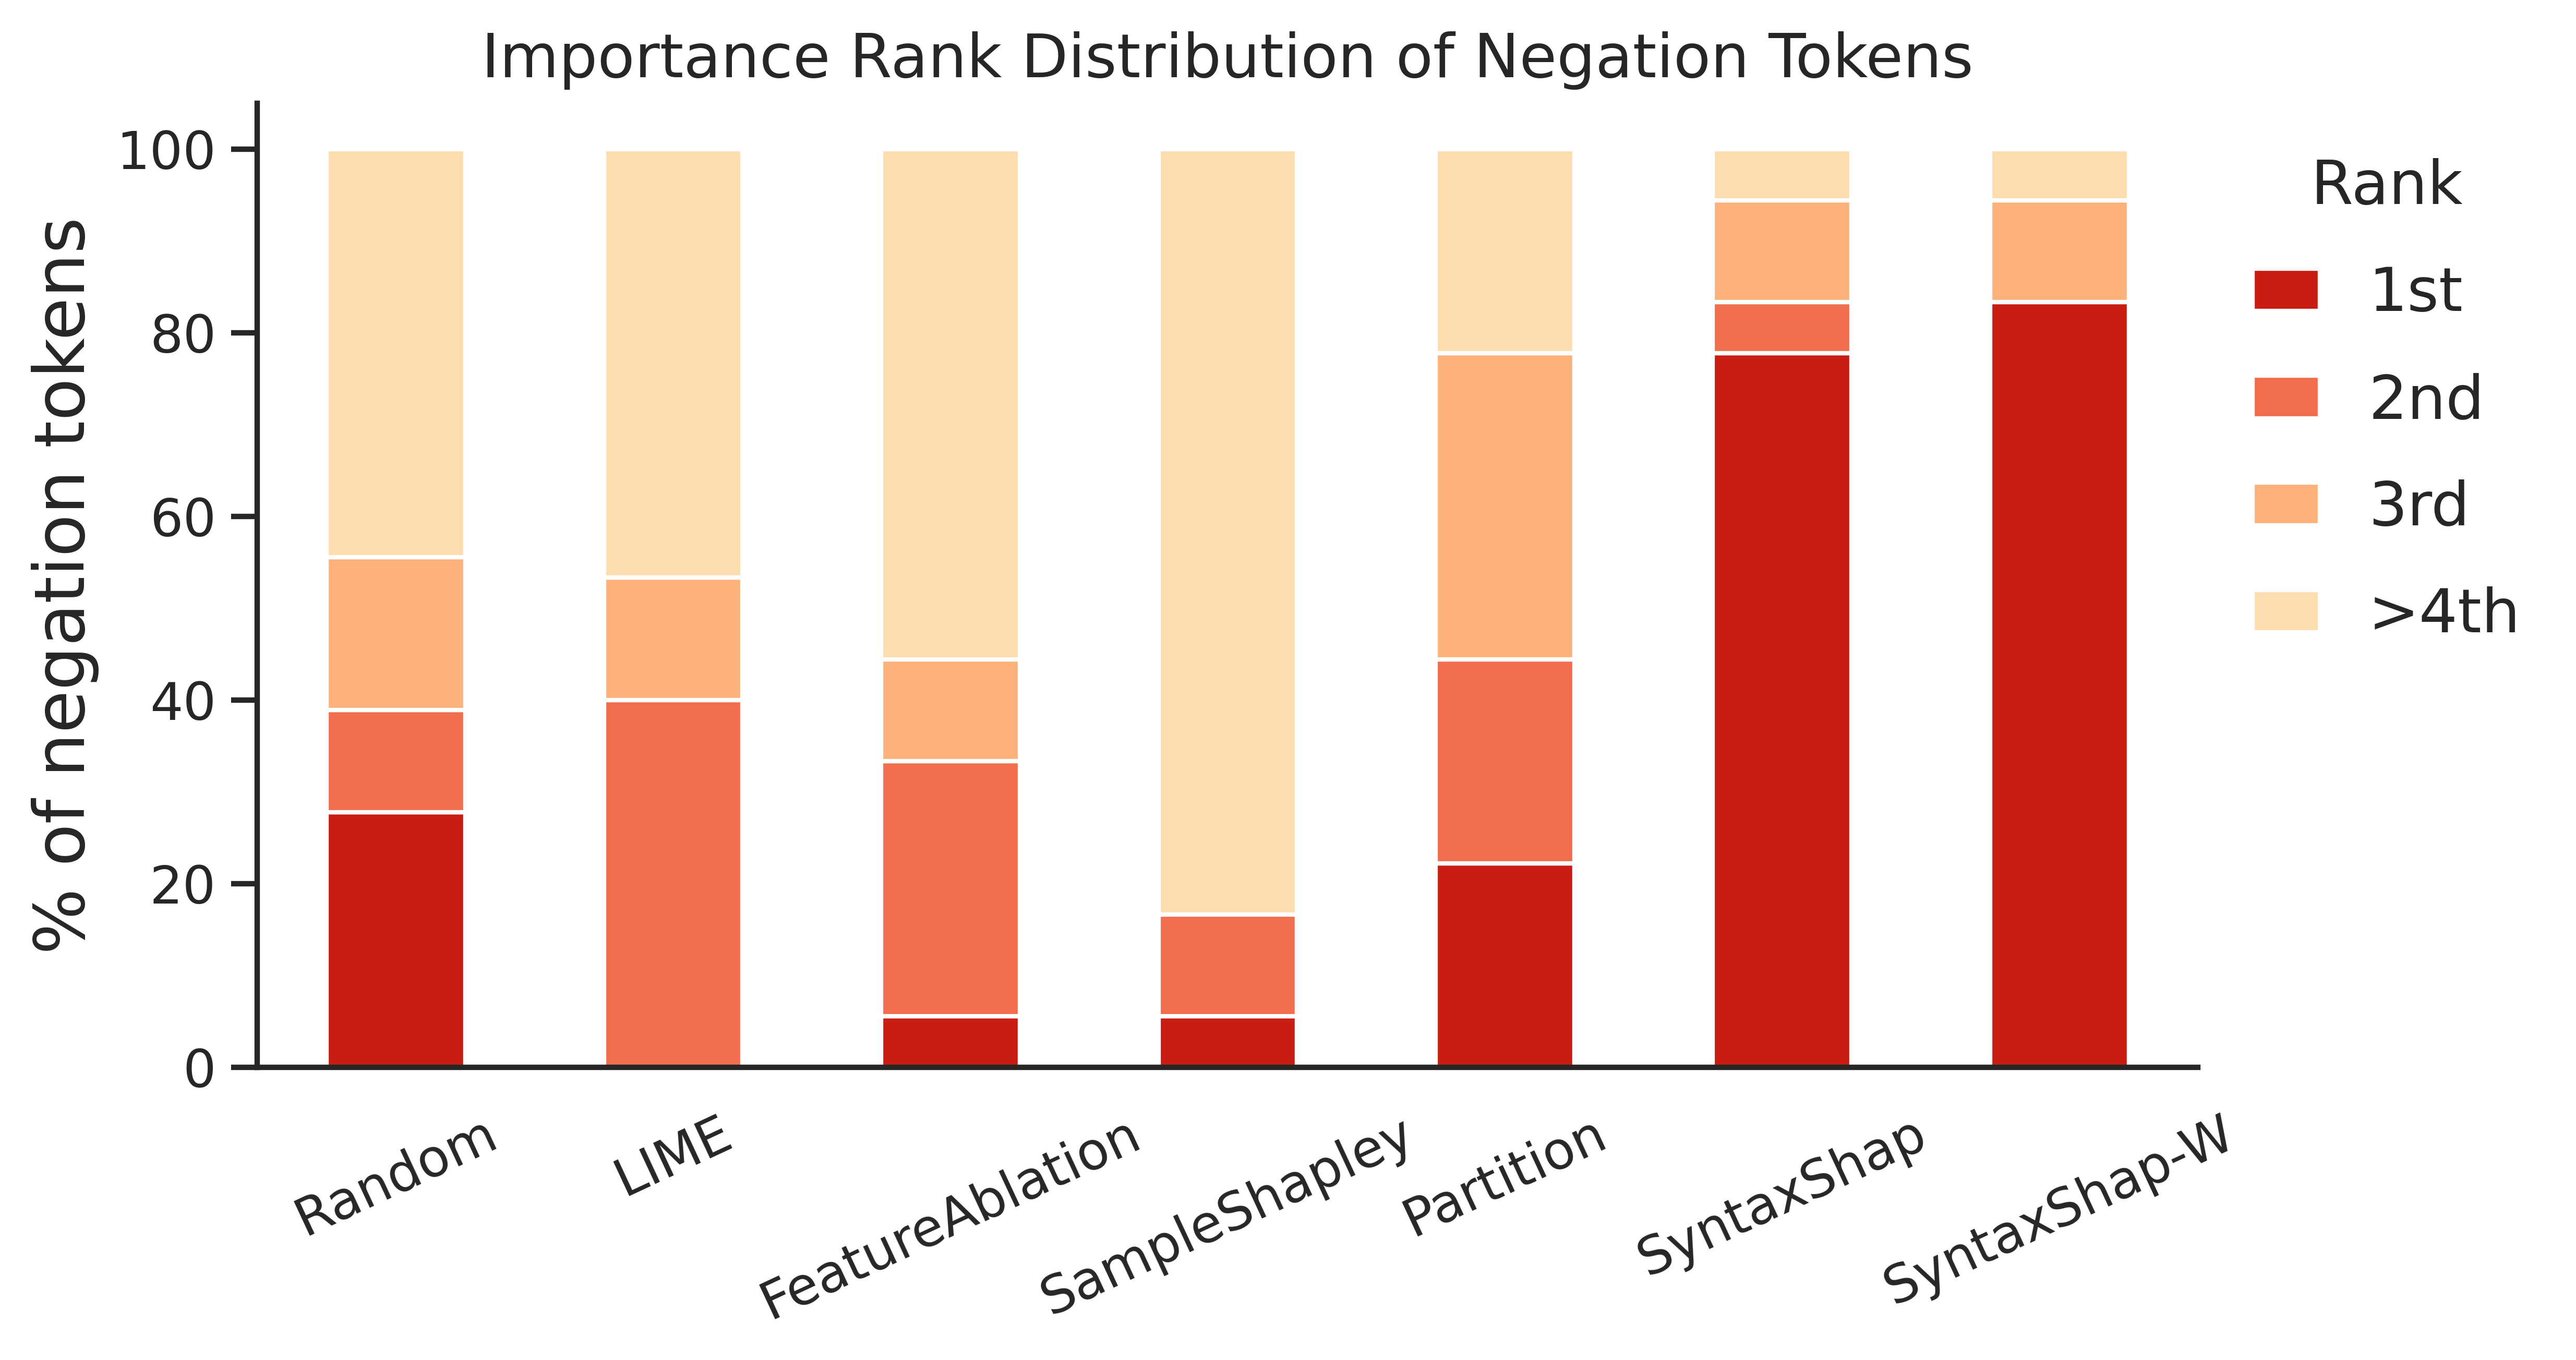

In [121]:

df = sample_with_y.copy()

# Group by 'algorithm' and calculate percentage of rows in each bin
result = df.groupby('algorithm')['neg_rank'].apply(lambda x: pd.cut(x, bins=[1, 2, 3, 4, float('inf')], right=False).value_counts(normalize=True) * 100).unstack().fillna(0)
#result.reset_index(inplace=True)
# Reorder rows and rename index
result = result.rename(index={'lime': 'LIME', 'ablation': 'FeatureAblation', 'svsampling': 'SampleShapley', 'hedge': 'Partition', 'syntax': 'SyntaxShap', 'syntax-w': 'SyntaxShap-W', 'random': 'Random'})
result = result.reindex(["Random", "LIME", "FeatureAblation","SampleShapley", "Partition", "SyntaxShap", "SyntaxShap-W"])

print(result)


sns.set_style("ticks")
sns.set_context("notebook", rc={"xtick.labelsize" : 12, "ytick.labelsize" : 12})
# Plot with increasing hue from Viridis colormap
plt.figure(figsize=(4,4))
result.plot(kind='bar', stacked=True, color=sns.color_palette("OrRd_r", n_colors=len(result.columns)), width=0.5, edgecolor='white', figsize=(8,4))

plt.title('Importance Rank Distribution of Negation Tokens', fontsize=14)
plt.xlabel('')
plt.ylabel('% of negation tokens', fontsize=16)
plt.xticks(rotation=25)
# Remove x ticks
plt.tick_params(axis='x', which='both', bottom=False)

# Move the legend outside on the upper right side of the plot
# Rewrite legend with custom labels and title
leg = plt.legend(labels=['1st', '2nd', '3rd', '>4th'], title='Rank', bbox_to_anchor=(1, 1), fontsize=14, loc='upper left', frameon=False, handlelength=1.1, labelspacing=0.8)
leg.get_title().set_fontsize('14')  # Increase legend title font size
for line in leg.get_lines():
    line.set_linewidth(3)  # Increase line width in legend

sns.despine()

#plt.tight_layout()
print(result)
plt.savefig(f"{save_dir}/figures/semantic_analysis/{dataset}_{model_name}_seed_{seed_}_negation_ranks.png", bbox_inches='tight', dpi=600)
plt.show()


In [122]:
df_neg = sample_with_y.groupby(['algorithm']).mean(numeric_only=True).reset_index()
df_neg

,algorithm,input_id,n_token,fid_keep_rd,fid_keep,fid_rmv,log_odds_keep,acc_at_k,prob_diff_at_k,label,neg_val,neg_rank
0,ablation,308.888889,6.777778,0.469291,0.467014,0.437927,-11.175333,0.022222,0.847350,0.0,0.375717,3.888889
1,hedge,308.888889,6.777778,0.350677,0.312601,0.350901,-7.392247,0.200000,0.693108,0.0,0.628646,2.666667
2,lime,303.333333,6.666667,0.492939,0.473556,0.442255,-8.872217,0.100000,0.758293,0.0,0.394606,3.533333
3,random,308.888889,6.777778,0.430608,0.393191,0.407768,-7.710713,0.127778,0.705356,0.0,0.529605,3.277778
4,svsampling,308.888889,6.777778,0.469291,0.469005,0.363491,-11.041595,0.016667,0.850187,0.0,0.305362,4.388889
5,syntax,308.888889,6.777778,0.421775,0.354670,0.448811,-5.495560,0.222222,0.580424,0.0,0.879852,1.444444
6,syntax-w,308.888889,6.777778,0.424086,0.389421,0.448126,-7.461308,0.166667,0.665773,0.0,0.861619,1.388889


In [123]:
sample_with_y

,input_id,input,explanation,algorithm,tokens,token_ids,n_token,fid_keep_rd,fid_keep,fid_rmv,log_odds_keep,acc_at_k,prob_diff_at_k,neg_pos,y,label,neg_val,neg_rank
0,422,Anna is a bride without a,"[0.0, 0.37837827, 1.0, 0.20797288, 0.119400665...",svsampling,"[<s>, Anna, is, a, bride, without, a]","[1, 11106, 349, 264, 25248, 1671, 264]",7,0.025213,0.025213,0.009812,-10.135153,0.0,0.832223,[4],groom,0.0,0.119401,5
1,422,Anna is a bride without a,"[1.0, 0.16025413150134257, 0.7235080162420673,...",random,"[<s>, Anna, is, a, bride, without, a]","[1, 11106, 349, 264, 25248, 1671, 264]",7,0.464713,0.464713,0.464713,-13.049177,0.0,0.832223,[4],groom,0.0,0.000000,6
2,422,Anna is a bride without a,"[1.0, 0.80428624, 0.7832184, 0.23082423, 0.0, ...",ablation,"[<s>, Anna, is, a, bride, without, a]","[1, 11106, 349, 264, 25248, 1671, 264]",7,0.025213,0.025213,-0.003361,-10.135153,0.0,0.832223,[4],groom,0.0,0.000000,6
3,422,Anna is a bride without a,"[0.05300887519644963, 0.0, 0.36619731922874493...",syntax-w,"[<s>, Anna, is, a, bride, without, a]","[1, 11106, 349, 264, 25248, 1671, 264]",7,0.034462,0.034462,0.034462,-10.447641,0.0,0.824840,[4],groom,0.0,1.000000,1
4,422,Anna is a bride without a,"[0.49454247379093147, 0.13535527848483542, 0.0...",hedge,"[<s>, Anna, is, a, bride, without, a]","[1, 11106, 349, 264, 25248, 1671, 264]",7,0.407776,-0.003703,0.464713,0.007937,0.5,0.177549,[4],groom,0.0,0.496510,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,370,John is a husband without a,"[1.0, 0.5987323, 0.7225867, 0.0, 0.8049463, 0....",ablation,"[<s>, John, is, a, husband, without, a]","[1, 2215, 349, 264, 5581, 1671, 264]",7,0.849870,0.849870,0.836500,-13.652841,0.0,0.962460,[4],wife,0.0,0.804946,2
119,370,John is a husband without a,"[0.016082838138235887, 0.0, 0.1965722271743465...",syntax-w,"[<s>, John, is, a, husband, without, a]","[1, 2215, 349, 264, 5581, 1671, 264]",7,0.846125,0.833364,0.849870,-3.941302,0.1,0.942412,[4],wife,0.0,1.000000,1
120,370,John is a husband without a,"[0.9776711844869578, 0.0, 0.5824641642032461, ...",hedge,"[<s>, John, is, a, husband, without, a]","[1, 2215, 349, 264, 5581, 1671, 264]",7,0.051039,0.051039,0.051039,-10.840359,0.0,0.962460,[4],wife,0.0,1.000000,1
121,370,John is a husband without a,"[1.0, 0.5185533661808323, 0.5194801230255031, ...",lime,"[<s>, John, is, a, husband, without, a]","[1, 2215, 349, 264, 5581, 1671, 264]",7,0.850813,0.850813,0.837405,-13.653950,0.0,0.962669,[4],wife,0.0,0.522408,2


      algorithm   neg_val
0    svsampling  0.119401
1        random  0.000000
2      ablation  0.000000
3      syntax-w  1.000000
4         hedge  0.496510
..          ...       ...
118    ablation  0.804946
119    syntax-w  1.000000
120       hedge  1.000000
121        lime  0.522408
122      syntax  1.000000

[123 rows x 2 columns]


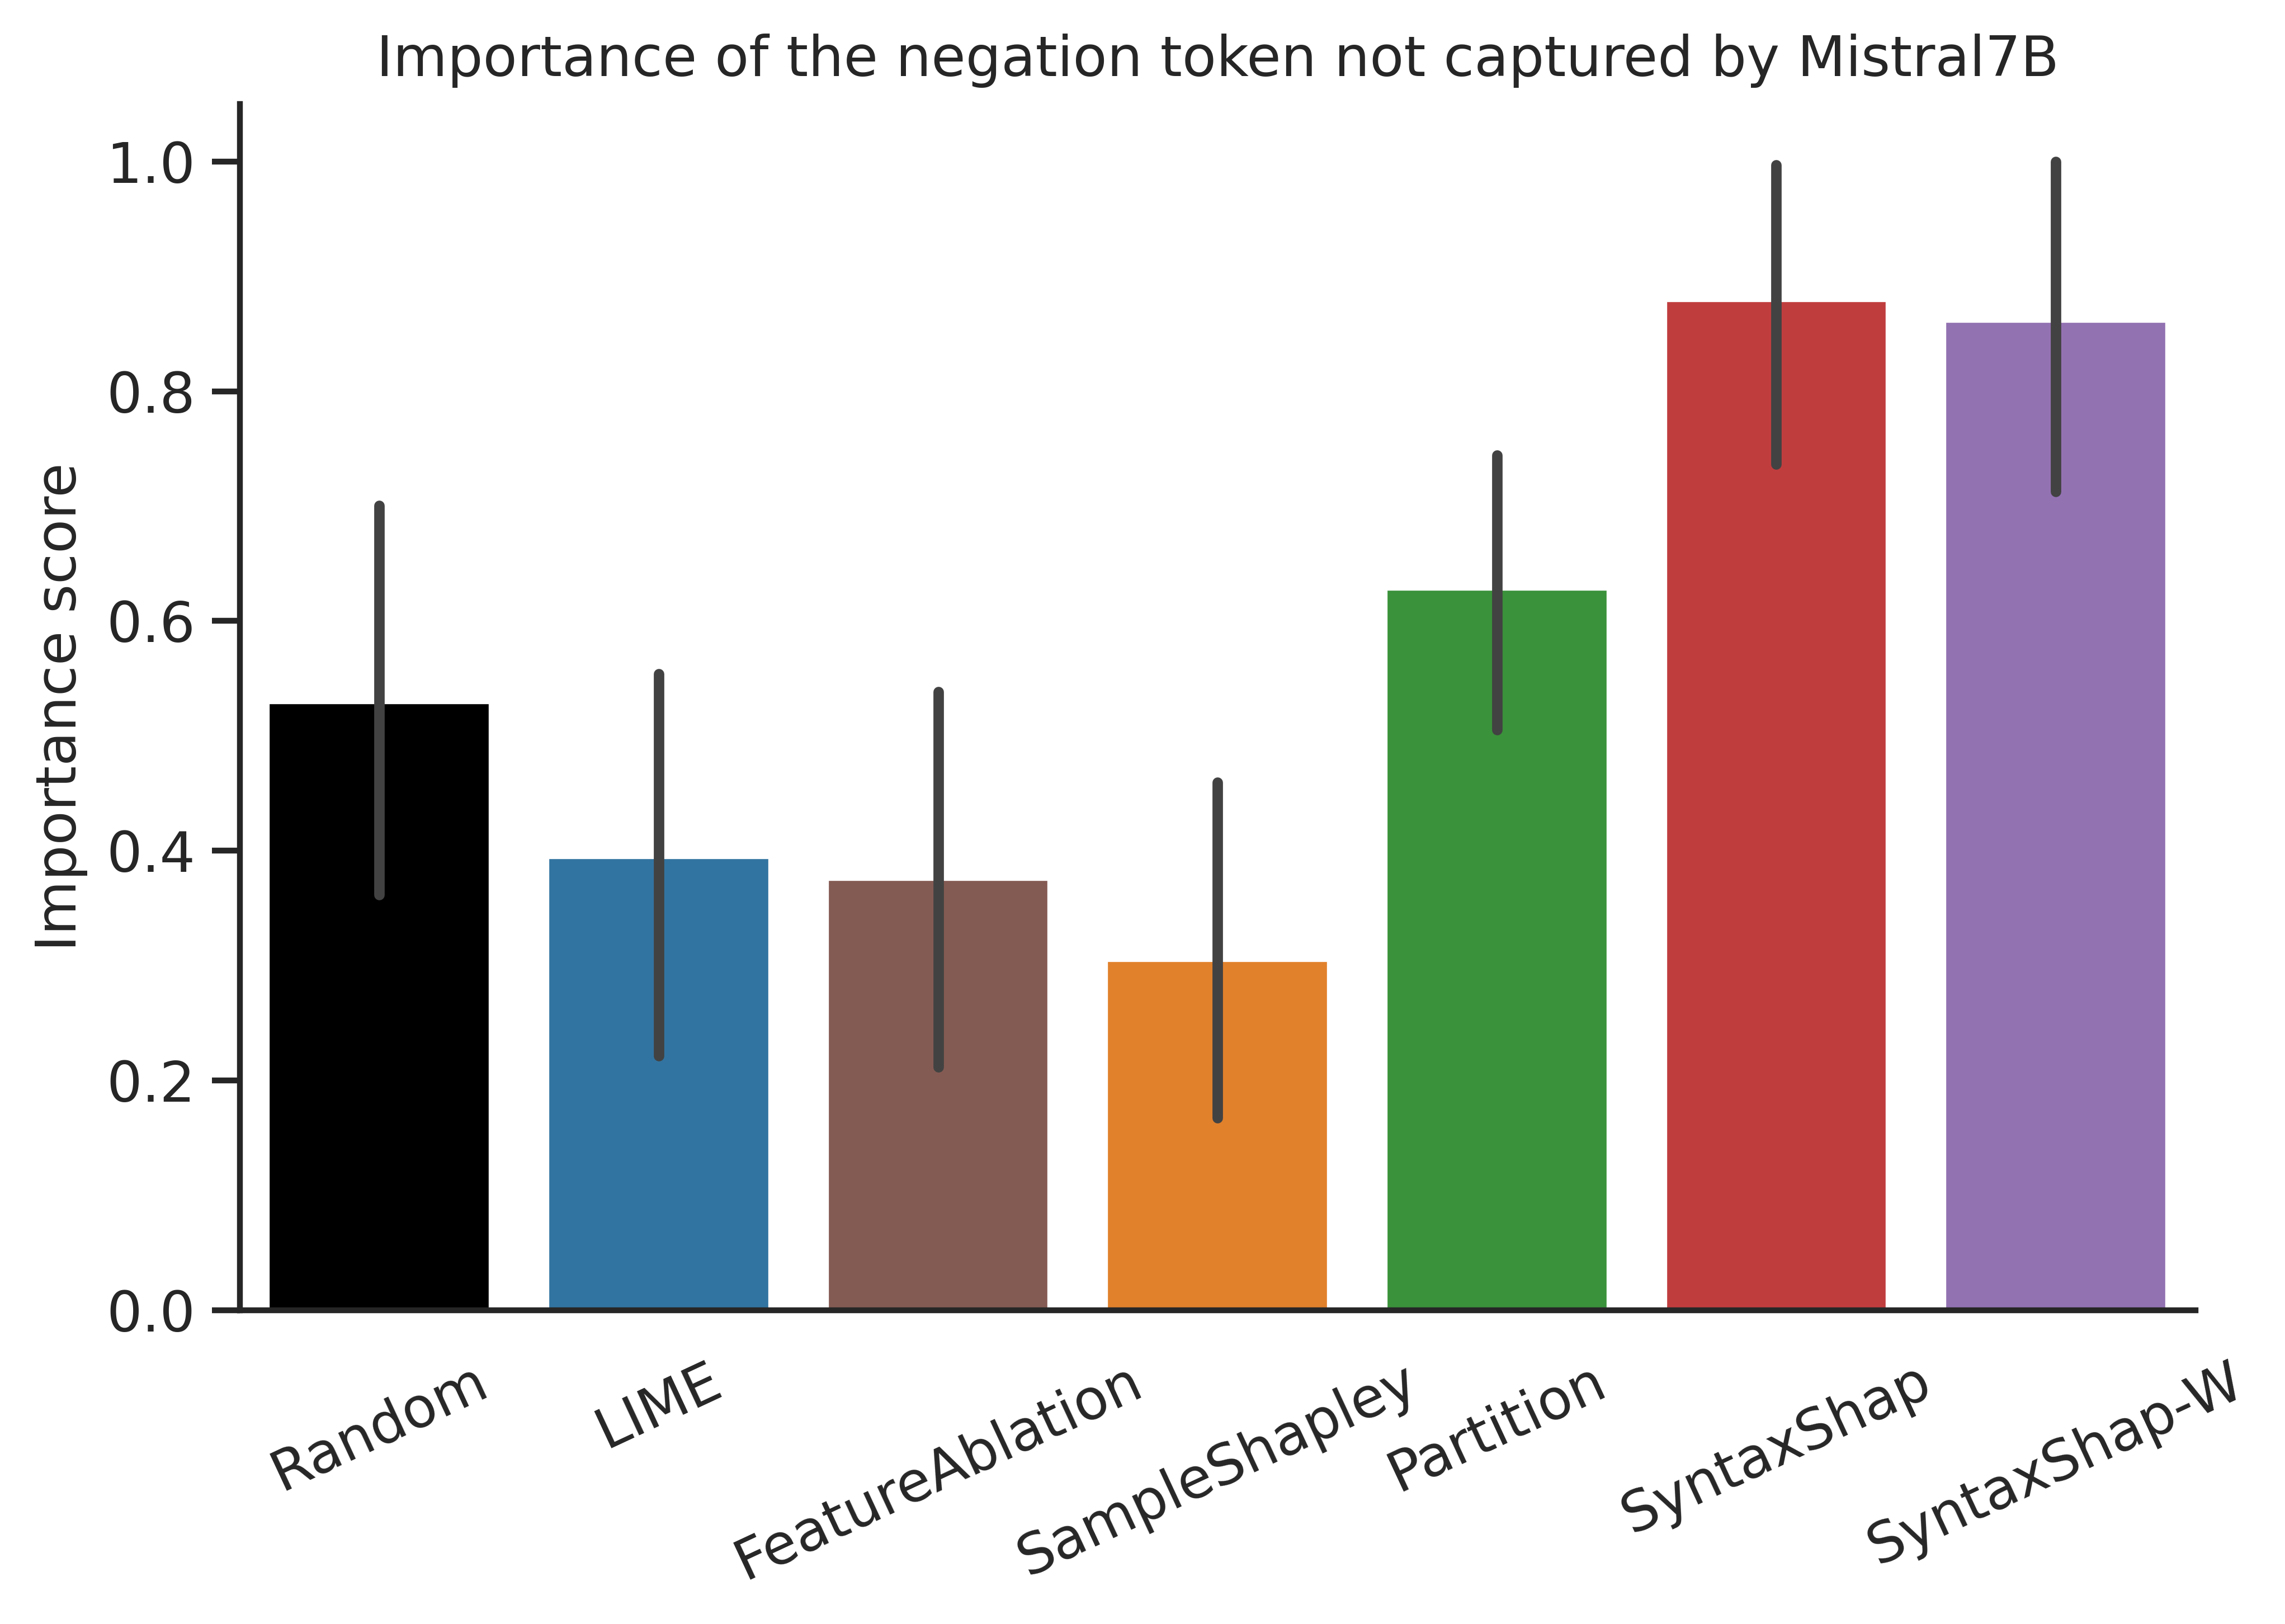

In [124]:
# Plot
df = sample_with_y.copy()
df = df[['algorithm', 'neg_val']]
print(df)

# Define the order of algorithms and a colormap
algo_order = ["random", "lime", "ablation", "svsampling", "hedge", "syntax", "syntax-w"]
pal = sns.color_palette("tab10", len(algo_order))

# Ensure 'algorithm' column is categorical and ordered
df['algorithm'] = pd.Categorical(df['algorithm'], categories=algo_order, ordered=True)
df['algorithm'] = df['algorithm'].replace({'lime': 'LIME', 'ablation': 'FeatureAblation', 'svsampling': 'SampleShapley', 'hedge': 'Partition', 'syntax': 'SyntaxShap', 'syntax-w': 'SyntaxShap-W', 'random': 'Random'})
dict_color = {"Random": 'black', "LIME": pal[0], "SampleShapley": pal[1], "Partition": pal[2], "SyntaxShap": pal[3], "SyntaxShap-W": pal[4], "FeatureAblation": pal[5]} 


# Adjusting various parameters
# Plotting with Seaborn
sns.set_style("ticks")
sns.set_context("notebook", rc={"xtick.labelsize" : 12, "ytick.labelsize" : 12})


plt.figure(figsize=(7,5))


sns.barplot(data=df, x='algorithm', y='neg_val', hue='algorithm', palette=dict_color)#, errorbar='se')
plt.title('Importance of the negation token not captured by Mistral7B')
plt.ylabel('Importance score')
plt.xlabel('')
plt.xticks(rotation=25)
# Remove x ticks
plt.tick_params(axis='x', which='both', bottom=False)
sns.despine()
plt.tight_layout()

plt.savefig(f"{save_dir}/figures/semantic_analysis/{dataset}_{model_name}_seed_{seed_}_negation_importance.png", bbox_inches='tight', dpi=600)

      algorithm  neg_rank
0    svsampling         5
1        random         6
2      ablation         6
3      syntax-w         1
4         hedge         3
..          ...       ...
118    ablation         2
119    syntax-w         1
120       hedge         1
121        lime         2
122      syntax         1

[123 rows x 2 columns]


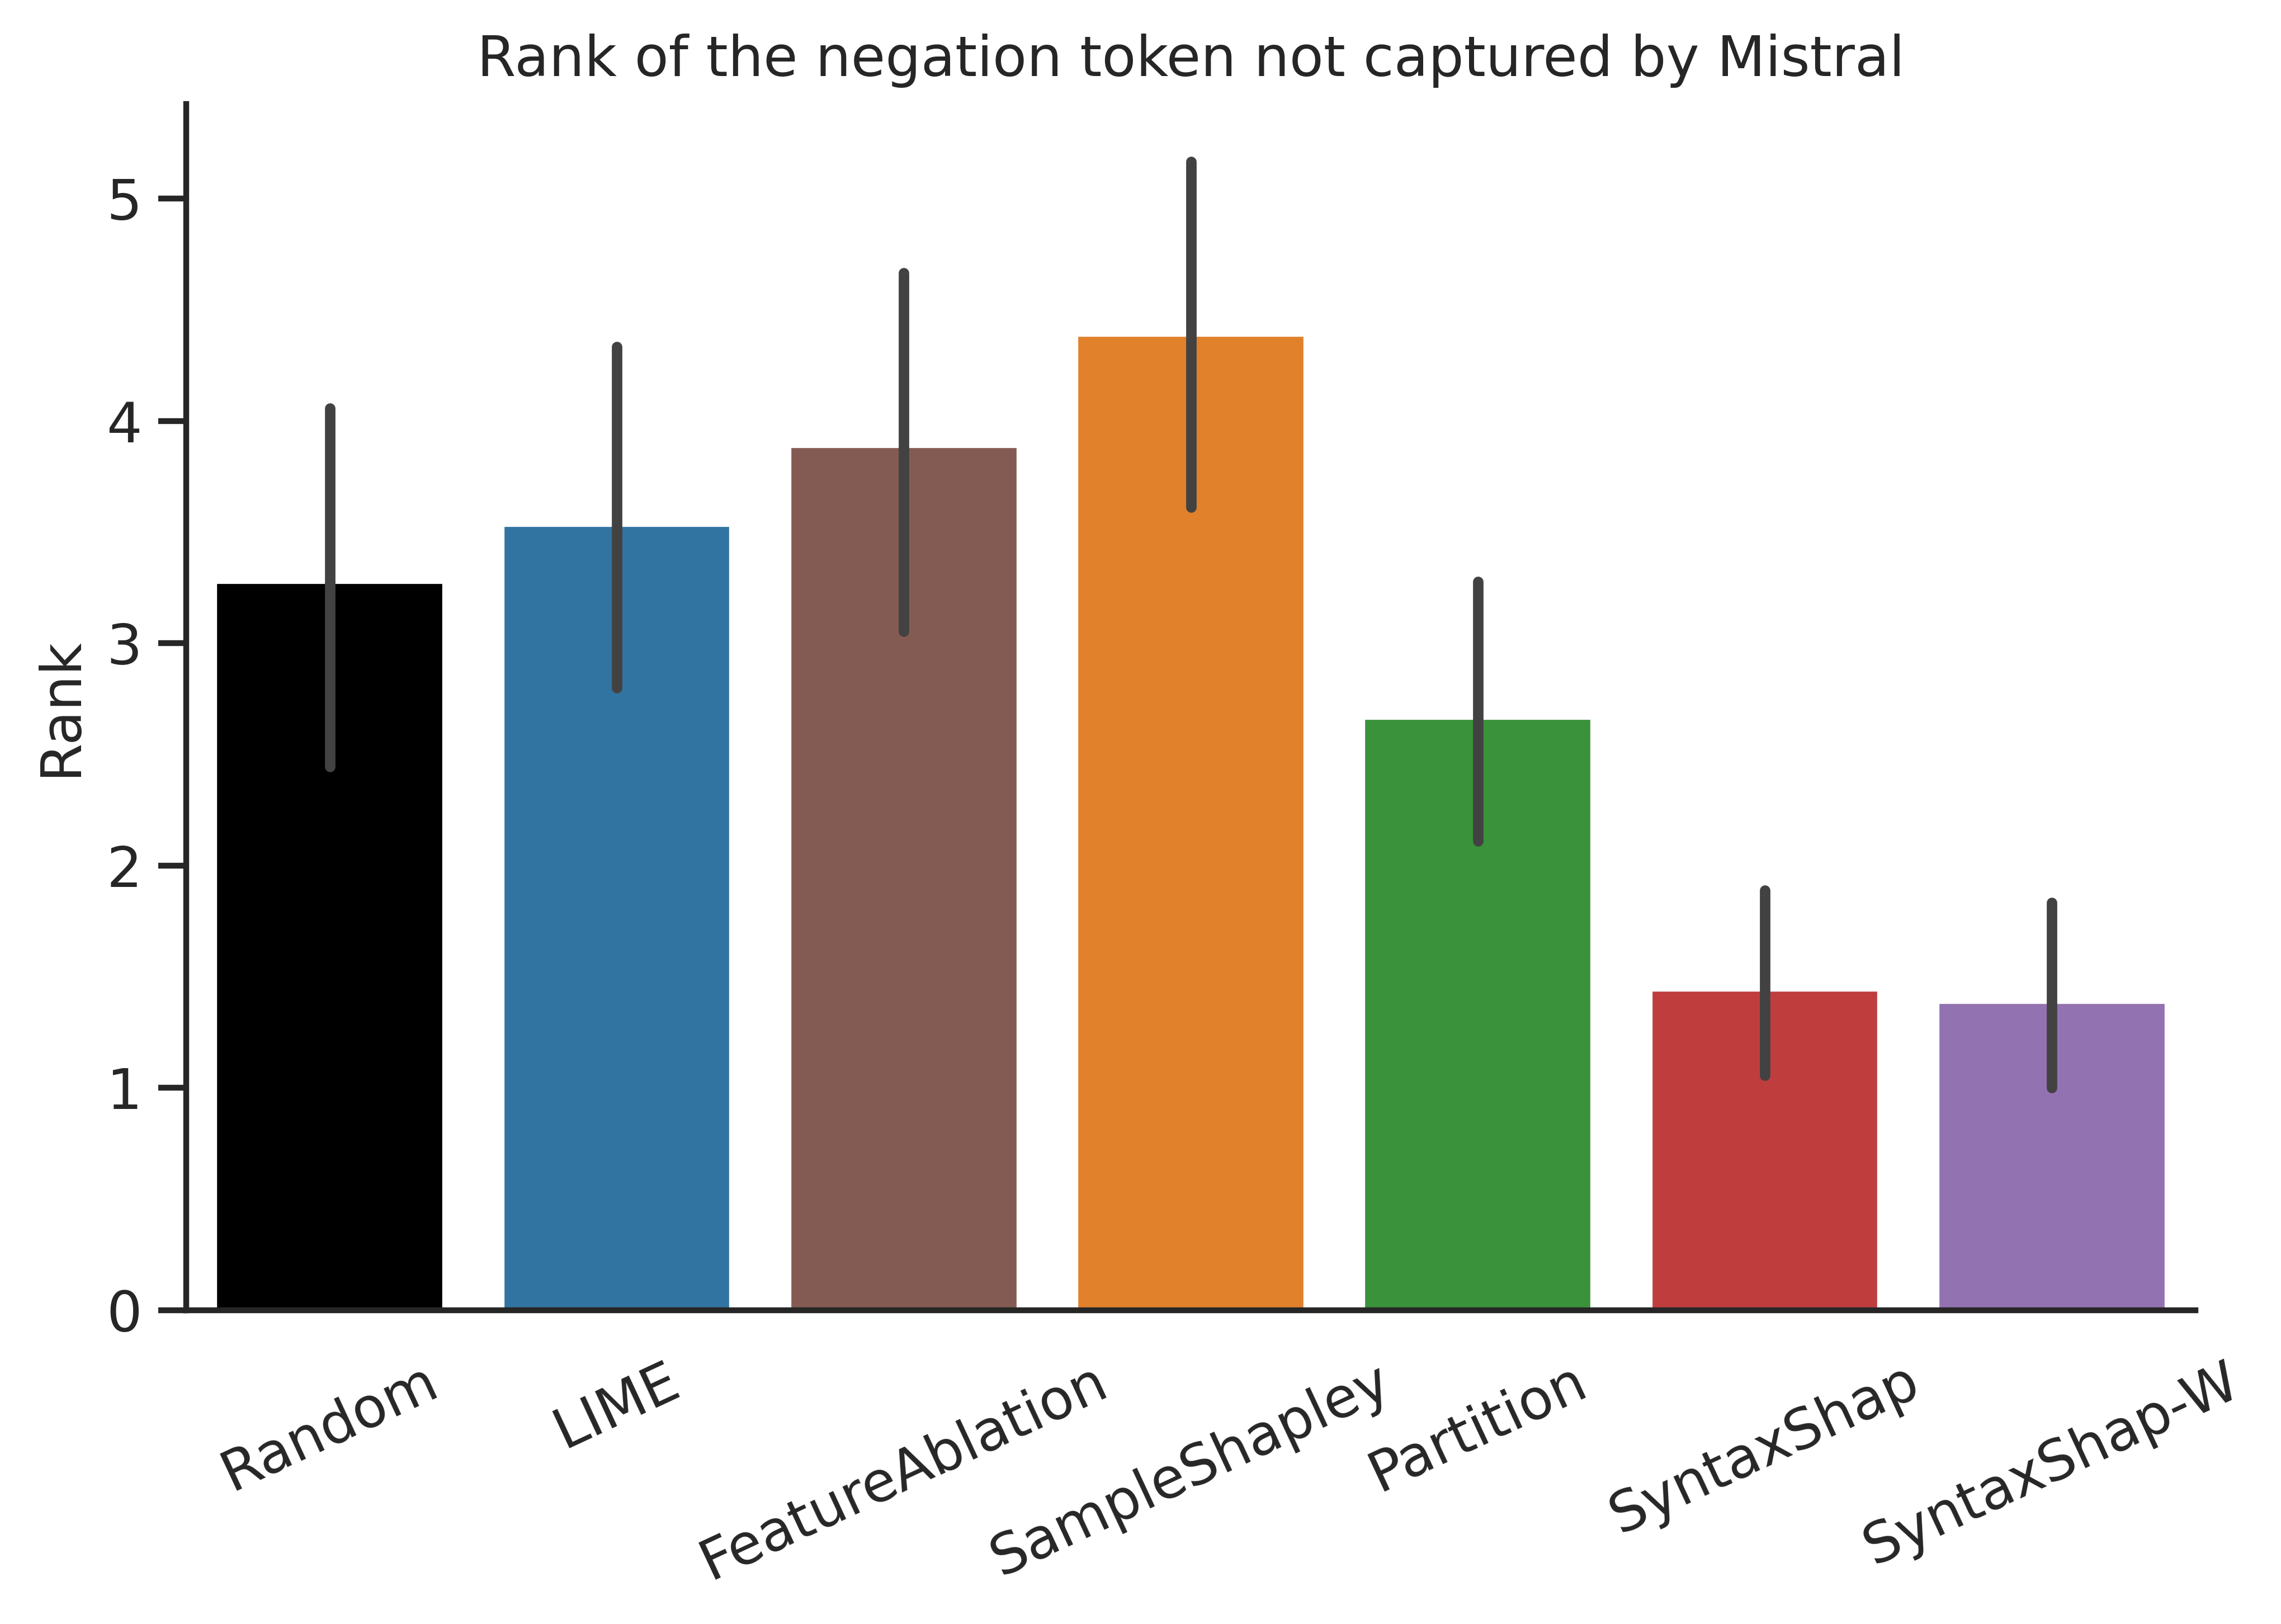

In [125]:
# Plot
df = sample_with_y.copy()
df = df[['algorithm', 'neg_rank']]
print(df)

# Define the order of algorithms and a colormap
algo_order = ["random", "lime", "ablation", "svsampling", "hedge", "syntax", "syntax-w"]
pal = sns.color_palette("tab10", len(algo_order))

# Ensure 'algorithm' column is categorical and ordered
df['algorithm'] = pd.Categorical(df['algorithm'], categories=algo_order, ordered=True)
df['algorithm'] = df['algorithm'].replace({'lime': 'LIME', 'ablation': 'FeatureAblation', 'svsampling': 'SampleShapley', 'hedge': 'Partition', 'syntax': 'SyntaxShap', 'syntax-w': 'SyntaxShap-W', 'random': 'Random'})
dict_color = {"Random": 'black', "LIME": pal[0], "SampleShapley": pal[1], "Partition": pal[2], "SyntaxShap": pal[3], "SyntaxShap-W": pal[4], "FeatureAblation": pal[5]} 


# Adjusting various parameters
# Plotting with Seaborn
sns.set_style("ticks")
sns.set_context("notebook", rc={"xtick.labelsize" : 12, "ytick.labelsize" : 12})


plt.figure(figsize=(7,5))


sns.barplot(data=df, x='algorithm', y='neg_rank', hue='algorithm', palette=dict_color)#, errorbar='se')
plt.title('Rank of the negation token not captured by Mistral')
plt.ylabel('Rank')
plt.xlabel('')
plt.xticks(rotation=25)
# Remove x ticks
plt.tick_params(axis='x', which='both', bottom=False)
sns.despine()
plt.tight_layout()

plt.savefig(f"{save_dir}/figures/semantic_analysis/{dataset}_{model_name}_seed_{seed_}_negation_rank.png", bbox_inches='tight', dpi=600)